In [ ]:
!pip install split-folders
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q torchaudio librosa boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.4 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, time, math, random, json

import torch
import torchaudio

from torch import nn
from torch.nn import functional as Functional
from torch.utils.data import DataLoader, Dataset

import torchaudio.functional as F
import torchaudio.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from prettytable import PrettyTable

In [ ]:

SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:

base_path = "/content/drive/My Drive/Audio/Covid_Sound"
os.chdir(base_path)
print(os.getcwd())
     

/content/drive/My Drive/Audio/Covid_Sound


In [ ]:
import splitfolders
input_path=os.getcwd()
new_path=os.path.split(os.getcwd())[0]
output_path=f"{new_path}/Covid_Sound2"
print(output_path)
splitfolders.ratio(input_path,output_path,seed=42,ratio=(.75,.25),group_prefix=None)


/content/drive/My Drive/Audio/Covid_Sound2


Copying files: 1356 files [00:38, 35.26 files/s]


In [ ]:
print(os.getcwd())
os.chdir(f'{os.path.split(os.getcwd())[0]}/Covid_Sound2')
print(os.getcwd())

/content/drive/My Drive/Audio/Covid_Sound
/content/drive/My Drive/Audio/Covid_Sound2


In [ ]:
base_path="/content/drive/My Drive/Audio/Covid_Sound2"
os.chdir(base_path)

In [ ]:
train_path=os.path.join(base_path,"train")
test_path=os.path.join(base_path,"val")

train_positive_path =  os.path.join(train_path, "Positive")
train_negative_path =  os.path.join(train_path, "Negative")
test_positive_path =  os.path.join(test_path, "Positive")
test_negative_path =  os.path.join(test_path, "Negative")

In [ ]:
from pathlib import Path
from pydub import AudioSegment
path_list=[train_negative_path,train_positive_path,test_negative_path,test_positive_path]
print(path_list)
i=0;j=0
for path in path_list:
    os.chdir(path)
    print(os.getcwd())
    for file in os.listdir():
        if "Positive" in os.getcwd():
           f=Path(file)
           name,ext=f.stem,f.suffix
           splitted=name.split("_")
           newname=f"Positive_{splitted[2]}_{i}{ext}"
           i+=1
           f.rename(newname)
          #  print(f)

           if file.endswith("mp3"):
              output=newname[:-4]
              sound=AudioSegment.from_mp3(newname)
              sound.export(f"{output}.wav",format="wav")
              os.remove(newname)
              
        else:
            f=Path(file)
            name,ext=f.stem,f.suffix
            splitted=name.split("_")
            newname=f"{splitted[1]}_{splitted[2]}_{j}{ext}"
            j+=1
            f.rename(newname)
            # print(f)

            if file.endswith("mp3"):
              output=newname[:-4]
              sound=AudioSegment.from_mp3(newname)
              sound.export(f"{output}.wav",format="wav")
              os.remove(newname)

['/content/drive/My Drive/Audio/Covid_Sound2/train/Negative', '/content/drive/My Drive/Audio/Covid_Sound2/train/Positive', '/content/drive/My Drive/Audio/Covid_Sound2/val/Negative', '/content/drive/My Drive/Audio/Covid_Sound2/val/Positive']
/content/drive/My Drive/Audio/Covid_Sound2/train/Negative
/content/drive/My Drive/Audio/Covid_Sound2/train/Positive
/content/drive/My Drive/Audio/Covid_Sound2/val/Negative
/content/drive/My Drive/Audio/Covid_Sound2/val/Positive


In [ ]:
waveform, sample_rate = torchaudio.load(os.path.join(train_positive_path, "Positive_male_111.wav"))
waveform, sample_rate

(tensor([[-0.0063, -0.0169, -0.0343,  ...,  0.0000,  0.0000,  0.0000]]), 48000)

In [ ]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [ ]:

play_audio(waveform, sample_rate)

In [ ]:
classes = ["negative", "positive"]
def load_audio(path:str):
  waveform, sample_rate = torchaudio.load(path)
  return waveform, sample_rate

def load_data(path, class_name):
  data = list()
  for audio in os.listdir(path):
    waveform, sample_rate = load_audio(os.path.join(path, audio))
    data.append([waveform, sample_rate, class_name, classes.index(class_name)])
  return data

In [ ]:
train_data = []
test_data = []

train_negative = load_data(train_negative_path, "negative")
train_positive = load_data(train_positive_path, "positive")

test_negative = load_data(test_negative_path, "negative")
test_positive= load_data(test_positive_path, "positive")
train_data = train_negative + train_positive
test_data = test_negative + test_positive

random.shuffle(train_data)
random.shuffle(test_data)


assert len(train_data) == len(train_positive) + len(train_negative)
assert len(test_data) == len(test_positive) + len(test_negative)

In [ ]:

train_data[60], #train_data[-1]

([tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 48000, 'negative', 0],)

Shape of waveform: torch.Size([1, 76792])
Sample rate of waveform: 48000
[[-0.00634766]
 [-0.01690674]
 [-0.03430176]
 ...
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


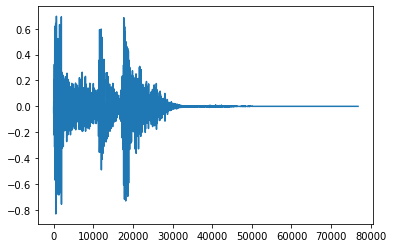

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy())
print(waveform.t().numpy())
plt.show()

In [ ]:

new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate,
                                           new_freq=new_sample_rate)
transformed = transform(waveform)

# playing the original sound
play_audio(waveform, sample_rate)

In [ ]:
play_audio(transformed, new_sample_rate )

In [ ]:

class NegativePositiveAudio(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.len = len(data)
    self.x = [i[0].numpy() for i in self.data]
    self.y = [i[-1] for i in self.data]
    self.transform = transform
      
  def __getitem__(self, index):
    sample = self.x[index], self.y[index]
    
    if self.transform:
        sample = self.transform(sample)
    return sample
  
  def __len__(self):
    return self.len

In [ ]:
class ToTensor:
  def __call__(self, samples):
    x, y = samples
    return torch.from_numpy(x.astype('float32')) ,torch.from_numpy(np.array(y, dtype='float32'))
     

In [ ]:

train =  NegativePositiveAudio(data=train_data, transform=ToTensor())
test  =  NegativePositiveAudio(data=test_data, transform=ToTensor())
     

In [ ]:
def tabulate(column_names, data):
  table = PrettyTable(column_names)
  for row in data:
    table.add_row(row)
  print(table)


column_names = ["SUBSET", "EXAMPLE(s)"]
data = [
        ["training", len(train)],
        ['validation/test', len(test)],
]
tabulate(column_names, data)
   

+-----------------+------------+
|      SUBSET     | EXAMPLE(s) |
+-----------------+------------+
|     training    |    1016    |
| validation/test |    340     |
+-----------------+------------+


In [ ]:

train[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor(0.))

In [ ]:
play_audio(train[0][0], sample_rate)

In [ ]:
def pad_sequence(batch):
  batch = [item.t() for item in batch]
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
  return batch.permute(0, 2, 1)

def collate_fn(batch):
  tensors, targets = [], []

  for waveform, label in batch:
    # apply the transformations, by downsampling the wavefor from sample_rate 16000 to 8000
    tensors += [transform(waveform)]
    targets += [label]
  tensors = pad_sequence(tensors)
  targets = torch.stack(targets)
  return tensors, targets
     

In [ ]:

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [ ]:

next(iter(train_loader))

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([0., 0., 0., 0., 0., 1., 0., 0.]))

In [ ]:
class M5(nn.Module):
  def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
    super(M5, self).__init__()
    self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
    self.bn1 = nn.BatchNorm1d(n_channel)
    self.pool1 = nn.MaxPool1d(4)

    self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(n_channel)
    self.pool2 = nn.MaxPool1d(4)

    self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
    self.bn3 = nn.BatchNorm1d(2 * n_channel)
    self.pool3 = nn.MaxPool1d(4)

    self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
    self.bn4 = nn.BatchNorm1d(2 * n_channel)
    self.pool4 = nn.MaxPool1d(4)

    self.fc1 = nn.Linear(2 * n_channel, n_output)


  def forward(self, x):
    x = self.conv1(x)
    x = Functional.relu(self.bn1(x))
    x = self.pool1(x)
    x = self.conv2(x)
    x = Functional.relu(self.bn2(x))
    x = self.pool2(x)
    x = self.conv3(x)
    x = Functional.relu(self.bn3(x))
    x = self.pool3(x)
    x = self.conv4(x)
    x = Functional.relu(self.bn4(x))
    x = self.pool4(x)
    x = Functional.avg_pool1d(x, x.shape[-1])
    x = x.permute(0, 2, 1)
    x = self.fc1(x)
    return x 

In [ ]:

model = M5(n_input=transformed.shape[0], n_output=1).to(device)
model

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")
     

Total number of paramaters: 24,705
Total tainable parameters: 24,705


In [ ]:
optimizer =torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

In [ ]:
def binary_accuracy(y_preds, y_true):
  #round predictions to the closest integer
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float() #convert into float for division 
  acc = correct.sum() / len(correct)
  return acc
     

In [ ]:
def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for X, y in iterator:
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    predictions = model(X).squeeze()
    loss = criterion(predictions, y.squeeze())
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for X, y in iterator:
      X = X.to(device)
      y = y.to(device)
      predictions = model(X).squeeze()
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)
     

In [ ]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
def visualize_training(start, end, train_loss, train_accuracy, val_loss, val_accuracy, title):
  data = [
       ["Training", f'{train_loss:.3f}', f'{train_accuracy:.3f}', f"{hms_string(end - start)}" ],
       ["Validation", f'{val_loss:.3f}', f'{val_accuracy:.3f}', "" ],       
  ]
  table = PrettyTable(["CATEGORY", "LOSS", "ACCURACY", "ETA"])
  table.align["CATEGORY"] = 'l'
  table.align["LOSS"] = 'r'
  table.align["ACCURACY"] = 'r'
  table.align["ETA"] = 'r'
  table.title = title
  for row in data:
    table.add_row(row)
  print(table)
     

In [ ]:
N_EPOCHS = 15
elist=[]
tloss=[]
vloss=[]
t_acc=[]
v_acc=[]
MODEL_NAME = "COVID-sound.pt"
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(model,
                                      train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model,
                                        test_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()
  elist.append(epoch)
  tloss.append(train_loss)
  vloss.append(valid_loss)
  t_acc.append(train_acc)
  v_acc.append(valid_acc)
  visualize_training(start, end, train_loss, train_acc, valid_loss, valid_acc, title)
  

+--------------------------------------------+
|     EPOCH: 01/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.347 |    0.884 | 0:00:12.75 |
| Validation | 0.324 |    0.887 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 02/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.293 |    0.890 | 0:00:05.12 |
| Validation | 0.317 |    0.887 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 03/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   

<function matplotlib.pyplot.show(*args, **kw)>

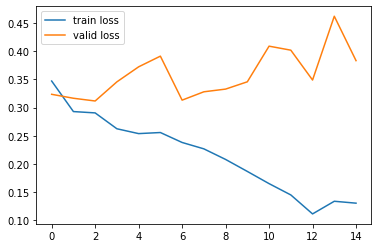

In [ ]:
plt.plot(elist,tloss,label="train loss")
plt.plot(elist,vloss,label="valid loss")
plt.legend()
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

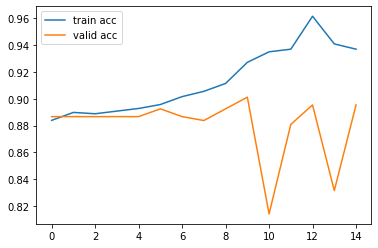

In [ ]:
plt.plot(elist,t_acc,label="train acc")
plt.plot(elist,v_acc,label="valid acc")
plt.legend()
plt.show

In [ ]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

def pad_sequence(batch):
  batch = torch.nn.utils.rnn.pad_sequence([batch], batch_first=True, padding_value=0.)
  return batch

def preprocess(waveform):
  waveform = pad_sequence(waveform)
  return transform(waveform)

In [ ]:
classes = ["negative", "positive"]

def predict_label(model, waveform):
  processed = preprocess(waveform).to(device)
  model.eval()
  with torch.no_grad():
    prediction = torch.sigmoid(model(processed).squeeze())
    probability = float(prediction.item()) if prediction.item() > .5 else 1 - prediction.item()
    label = 1 if prediction.item() >= 0.5 else 0
    pred =  {
        'label': label,
        'class': classes[label],
        'probability':round(probability, 2),
    }
    return pred
    
predict_label(model, train_data[0][0])


{'label': 0, 'class': 'negative', 'probability': 0.99}

In [ ]:

play_audio(train_data[0][0], sample_rate)

In [ ]:
predict_label(model, train_data[1][0])
play_audio(train_data[1][0], sample_rate)

In [ ]:
play_audio(train_data[1][0], sample_rate)
     


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
def plot_confusion_matrix(labels:list, pred_labels:list, classes:list=[]):
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  cm = confusion_matrix(labels, pred_labels)

  if len(classes) == 0:
    classes = labels.numpy()

  cm = ConfusionMatrixDisplay(cm, display_labels= classes)
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20, color="black", fontsize=15)
  plt.yticks(rotation = 20, color="black", fontsize=15)
     

In [ ]:
y_true =[]
y_preds = []

for X, _, __, y in test_data[:140]:
  X = preprocess(X)
  X = X.to(device)
  y_true.append(y)
  # print(model(X))
  # prediction=model(X).splitI(" ")
  prediction = torch.sigmoid(model(X).squeeze())
  label = 1 if prediction.item() >= 0.5 else 0
  y_preds.append(label)


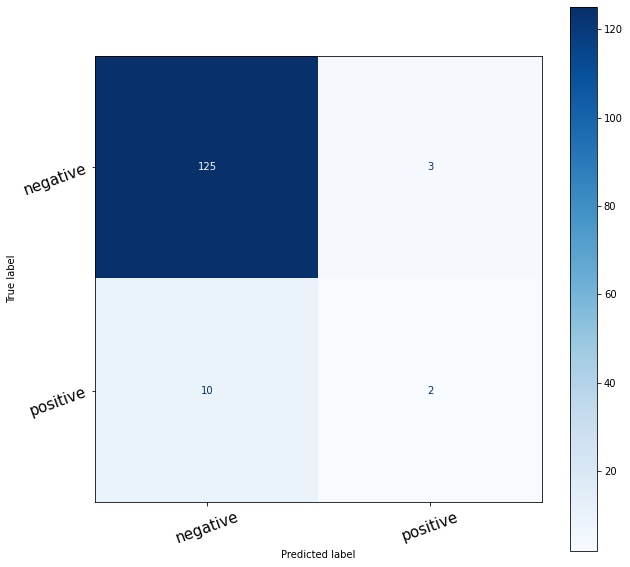

In [ ]:
plot_confusion_matrix(y_true, y_preds, classes)

In [ ]:

from sklearn.metrics import classification_report

In [ ]:
cr = classification_report(y_true, y_preds, output_dict=False, labels=y_true, target_names =[classes[i] for i in y_true])
print(cr)

              precision    recall  f1-score   support

    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    positive       0.40      0.17      0.24        12
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    negative       0.93      0.98      0.95       128
    positive       0.40      0.17      0.24        12
    negative       0.93    